In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
# Load dataset
dataset = pd.read_csv('/kaggle/input/daily-historical-stock-prices-1970-2018/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [4]:
# Separate train and test data
train_data = dataset[:'2017'].sort_values(by=['ticker','date'])
test_data = dataset['2018-01-01':'2018-06-30'].sort_values(by=['ticker','date'])

In [5]:
timesteps = 60

In [6]:
# All symbols
symbols = dataset.ticker.unique()

In [7]:
def make_train_set(data,s):
    l = len(data)
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        y = data[i,0]
        
        x = x.reshape(-1,1)
        y = y.reshape(-1,1)
        
        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)

        train_set[s]['x'].append(sc.transform(x))
        train_set[s]['y'].append(sc.transform(y))

In [8]:
# Define train_set
# Due to the limitation of cloud cpu, a few symbols are considered for trainning
train_set = {}
for s in ['A', 'ACER', 'MSFT', 'ABC', 'AAPL']:  
    train_set.update({s:{'x':[],'y':[]}})
    data = train_data.loc[train_data['ticker'] == s][['adj_close']].values

    make_train_set(data,s)

In [9]:
# Define earlystopping callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [10]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(60,1), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [11]:
# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = make_gru_network() # define your model normally
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
# Training multi symbols model
for s in train_set:
    print ("Training {}".format(s))
    X_train, Y_train = np.array(train_set[s]['x']), np.array(train_set[s]['y'])
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])

    print(X_train.shape, Y_train.shape)
    # train model normally
    model_history= model.fit(X_train, Y_train, epochs = 20, batch_size = 60, 
                                    validation_split = 0.3,callbacks=[es])

Training A
(4498, 60, 1) (4498,)
Train on 3148 samples, validate on 1350 samples
Epoch 1/20
3148/3148 [==============================] - 4s 1ms/step - loss: 0.1552 - val_loss: 0.0322
Epoch 2/20
3148/3148 [==============================] - 3s 845us/step - loss: 0.0358 - val_loss: 0.0226
Epoch 3/20
3148/3148 [==============================] - 3s 850us/step - loss: 0.0243 - val_loss: 0.0181
Epoch 4/20
3148/3148 [==============================] - 3s 849us/step - loss: 0.0202 - val_loss: 0.0151
Epoch 5/20
3148/3148 [==============================] - 3s 853us/step - loss: 0.0172 - val_loss: 0.0141
Epoch 6/20
3148/3148 [==============================] - 3s 852us/step - loss: 0.0164 - val_loss: 0.0134
Epoch 7/20
3148/3148 [==============================] - 3s 838us/step - loss: 0.0159 - val_loss: 0.0126
Epoch 8/20
3148/3148 [==============================] - 3s 862us/step - loss: 0.0148 - val_loss: 0.0132
Epoch 9/20
3148/3148 [==============================] - 3s 843us/step - loss: 0.0146 - va

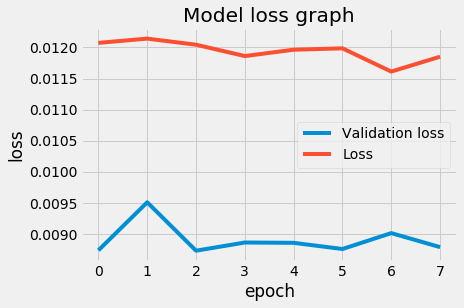

In [12]:
# Plotting validation loss and loss
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.plot(model_history.history['loss'], label='Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model loss graph')
plt.legend()
plt.show()

# Testing method 1

In [13]:
# Test a particular symbol by using Test data
s = "AAPL"
test_adj_close_values = test_data.loc[test_data['ticker'] == s][['adj_close']].values

In [14]:
def make_test_set(s, data):
    l = len(data)
    scaler = []
    test_set = {'x':[], 'y':[]}
    y_true = []
    
    for i in range(timesteps, l):
        x = data[i-timesteps: i, 0]
        y = data[i,0]
        y_true.append(y)

        x = x.reshape(-1,1)
        y = y.reshape(-1,1)

        sc = MinMaxScaler(feature_range=(0,1))
        sc.partial_fit(x)
        sc.partial_fit(y)

        scaler.append(sc)

        test_set['x'].append(sc.transform(x))
        test_set['y'].append(sc.transform(y))
        
    return test_set, y_true, scaler

In [15]:
def make_prediction(s, data):
    test_set, y_true, scaler = make_test_set(s, data)
    X_test = np.array(test_set['x'])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    result = model.predict(X_test)
    y_pred = []
    for i in range(0,len(result)):
        y = result[i]
        y = y.reshape(-1,1)
        k = scaler[i].inverse_transform(y)
        y_pred.append(k[0][0])
    return y_true, y_pred

In [16]:
y_true, y_pred = make_prediction(s, test_adj_close_values)

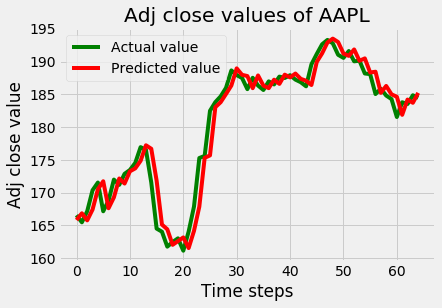

In [17]:
# Plotting actual vs predicted values
plt.plot(y_true, color='green', label='Actual value')
plt.plot(y_pred, color='red', label='Predicted value')
plt.xlabel('Time steps')
plt.ylabel('Adj close value')
plt.title('Adj close values of {}'.format(s))
plt.legend()
plt.show()

# Testing method 2

In [18]:
# Take timesteps input
test_input = test_data.loc[test_data['ticker'] == s][['adj_close']].values[0:timesteps]
# Predict numbers of days into the future
n_days = 10

In [19]:
# Make prediction by using predicted values or combination of real values and predicted values
def make_prediction_2(test_data, all_data):
    test_data.reshape(-1,1)
    sc = MinMaxScaler(feature_range=(0,1))
    X_test = np.array(sc.fit_transform(test_data))
    X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
    result = model.predict(X_test)
    for i in range(0,len(result)):
        y = result[i]
        y = y.reshape(-1,1)
        k = sc.inverse_transform(y)
        y_pred = k[0][0]
        
    all_data.append(y_pred)
    if len(all_data) == n_days:
        return all_data
    else:
        new_test_data = np.append(np.delete(test_data,0), [y_pred]).reshape(-1,1)
        return make_prediction_2(new_test_data, all_data)

In [20]:
# List of predicted values
y_pred_2 = make_prediction_2(test_input, [])

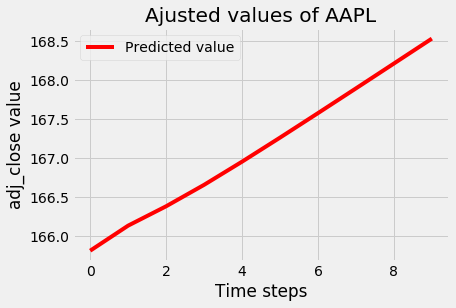

In [21]:
# Plotting graph
plt.plot(y_pred_2, color='red', label='Predicted value')
plt.xlabel('Future Days')
plt.ylabel('adj_close value')
plt.title('Ajusted values of {}'.format(s))
plt.legend()
plt.show()